In [2]:
import os
import time
import tqdm
import inceptionv3
import numpy as np
import tensorflow as tf

import utils
import defense

/home/stanislas/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stanislas/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stanislas/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stanislas/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

In [3]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config)

In [4]:
data_path = "./data"
output_path = "./finalresults"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [5]:
cleandata = np.load(os.path.join(data_path, "clean100data.npy"))
cleanlabel = np.load(os.path.join(data_path, "clean100label.npy"))
targets = np.load(os.path.join(data_path, "random_targets.npy"))

In [7]:
xs = tf.placeholder(tf.float32, (299, 299, 3))
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
label = tf.placeholder(tf.int32, ())
one_hot = tf.expand_dims(tf.one_hot(label, 1000), axis=0)

lam = 1e-6
epsilon = 0.05
max_steps = 1000
LR = 0.1

label = tf.placeholder(tf.int32, ())
one_hot = tf.expand_dims(tf.one_hot(label, 1000), axis=0)

logits, preds = inceptionv3.model(sess, tf.expand_dims(xs, axis=0))
l2_loss = tf.sqrt(2 * tf.nn.l2_loss(l2_x - l2_orig) / (299, 299, 3))

labels = tf.tile(one_hot, (logits.shape[0], 1))
xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
loss = xent + lam * tf.maximum(l2_loss - epsilon, 0)
grad, = tf.gradients(loss, xs)

INFO:tensorflow:Scale of 0 disables regularizer.


# Without defense

In [ ]:
adv = np.copy(data)
for index in range(data.shape[0]):

    adv_bpda = np.copy(adv[index])

    for i in tqdm.tqdm(range(max_steps)):
        p, l2 = sess.run([preds, l2_loss], {xs: adv_bpda, l2_x: adv_bpda, l2_orig: data[index]})
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def[0], label: targets[index]})
        adv_bpda -= lr * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda

# Adopt the BPDA over RDDfense

In [ ]:
adv = np.copy(data)
for index in range(data.shape[0]):

    adv_bpda = np.copy(adv[index])

    for i in tqdm.tqdm(range(max_steps)):
        adv_def = defense.defend_FD_sig(adv_bpda)
        adv_def = defense.defended(defense_func, np.expand_dims(adv_def, axis=0))
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def[0], l2_x: adv_bpda, l2_orig: data[index]})
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def[0], label: targets[index]})
        adv_bpda -= lr * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda

In [10]:
np.save(path+'/NoDAcc.npy', AccList)
np.save(path+'/NoDSuc.npy', SuccessList)
np.save(path+'/NoDL2.npy', L2List)
np.save(path+'/NoDLinf.npy', LinfList)

In [ ]:
# RDD (RDG+FD)
funcname = 'GD'

LAM = 1.0
AccList_BPDA = []
L2List_BPDA = []
LinfList_BPDA = []
SuccessList_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50


adv_bpda = np.copy(cleandata)
start = time.time()
for i in tqdm.tqdm(range(50)):
     
    fdadv_bpda = defend_FD(adv_bpda)
    defendadv_bpda = defended(funcname, fdadv_bpda)
    p_B= sess.run(preds,{x: defendadv_bpda})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_BPDA.append(Accuracy_B)
    
    L2 = l2_distortion(adv_bpda, cleandata)
    Linf = linf_distortion(adv_bpda, cleandata)
    
    L2List_BPDA.append(L2)
    LinfList_BPDA.append(Linf)
    SuccessList_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)
        fdadv_bpda_batch = defend_FD(adv_bpda_batch)
        adv_defbatch = defended(funcname, fdadv_bpda_batch)
        g_bpda = sess.run(grad, {x: adv_defbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

In [19]:
np.save(path+'/RDD_BPDA_Acc.npy', AccList_BPDA)
np.save(path+'/RDD_BPDA_Suc.npy', SuccessList_BPDA)
np.save(path+'/RDD_BPDA_L2.npy', L2List_BPDA)
np.save(path+'/RDD_BPDA_Linf.npy', LinfList_BPDA)

In [7]:
# RANDONLY
funcname = 'onlyrand'

LAM = 1.0
AccList_RAND_BPDA = []
L2List_RAND_BPDA = []
LinfList_RAND_BPDA = []
SuccessList_RAND_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50


adv_bpda = np.copy(cleandata)
start = time.time()
for i in tqdm.tqdm(range(50)):
     

    defendadv_bpda = defended(funcname, adv_bpda)
    p_B,l2_B = sess.run(preds,{x: defendadv_bpda, lam: LAM,l2_x: adv_bpda, l2_orig: cleandata})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_RAND_BPDA.append(Accuracy_B)
    
    L2 = l2_distortion(adv_bpda, cleandata)
    Linf = linf_distortion(adv_bpda, cleandata)
    
    L2List_RAND_BPDA.append(L2)
    LinfList_RAND_BPDA.append(Linf)
    
    SuccessList_RAND_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)

        adv_defbatch = defended(funcname, adv_bpda_batch)
        g_bpda, p_bpda = sess.run([grad, preds], {x: adv_defbatch,lam: LAM,l2_x: adv_bpda_batch, l2_orig: cleanbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

100%|██████████| 50/50 [04:39<00:00,  5.59s/it]

total time: 279.48449897766113


In [8]:
np.save(path+'/RAND_BPDA_Acc.npy', AccList_RAND_BPDA)
np.save(path+'/RAND_BPDA_Suc.npy', SuccessList_RAND_BPDA)
np.save(path+'/RAND_BPDA_L2.npy', L2List_RAND_BPDA)
np.save(path+'/RAND_BPDA_Linf.npy', LinfList_RAND_BPDA)

In [ ]:
# RAND+FD
funcname = 'onlyrand'

LAM = 1.0
AccList_RAND_FD_BPDA = []
L2List_RAND_FD_BPDA = []
LinfList_RAND_FD_BPDA = []
SuccessList_RAND_FD_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50


adv_bpda = np.copy(cleandata)
start = time.time()
for i in tqdm.tqdm(range(50)):
     
    fdadv_bpda = defend_FD(adv_bpda)
    defendadv_bpda = defended(funcname, fdadv_bpda)
    p_B,l2_B = sess.run([preds,normalized_l2_loss],{x: defendadv_bpda, lam: LAM,l2_x: adv_bpda, l2_orig: cleandata})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_RAND_FD_BPDA.append(Accuracy_B)
    
    L2 = l2_distortion(adv_bpda, cleandata)
    Linf = linf_distortion(adv_bpda, cleandata)
    
    L2List_RAND_FD_BPDA.append(L2)
    LinfList_RAND_FD_BPDA.append(Linf)
    
    SuccessList_RAND_FD_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)
        fdadv_bpda_batch = defend_FD(adv_bpda_batch)
        adv_defbatch = defended(funcname, fdadv_bpda_batch)
        g_bpda, p_bpda = sess.run([grad, preds], {x: adv_defbatch,lam: LAM,l2_x: adv_bpda_batch, l2_orig: cleanbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

In [26]:
np.save(path+'/RAND_FD_BPDA_Acc.npy', AccList_RAND_FD_BPDA)
np.save(path+'/RAND_FD_BPDA_Suc.npy', SuccessList_RAND_FD_BPDA)
np.save(path+'/RAND_FD_BPDA_L2.npy', L2List_RAND_FD_BPDA)
np.save(path+'/RAND_FD_BPDA_Linf.npy', LinfList_RAND_FD_BPDA)

In [ ]:
# FD
funcname = 'FD'
LAM = 1.0
AccList_FD_BPDA = []
SuccessList_FD_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50

adv_bpda = np.copy(cleandata)
start = time.time()
for i in tqdm.tqdm(range(50)):
    
    
    defendadv_bpda = cropresult(defend_FD(padresult(adv_bpda)))
    p_B,l2_B = sess.run([preds,normalized_l2_loss],{x: defendadv_bpda, lam: LAM,l2_x: adv_bpda, l2_orig: cleandata})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_FD_BPDA.append(Accuracy_B)
    SuccessList_FD_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)
        adv_defbatch = cropresult(defend_FD(padresult(adv_bpda_batch)))
        g_bpda, p_bpda = sess.run([grad, preds], {x: adv_defbatch,lam: LAM,l2_x: adv_bpda_batch, l2_orig: cleanbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

In [27]:
np.save(path+'/FD_BPDA_Acc.npy', AccList_FD_BPDA)
np.save(path+'/FD_BPDA_Suc.npy', SuccessList_FD_BPDA)

In [ ]:
# PD
funcname = 'pixel_deflection'
LAM = 1.0
AccList_PD_BPDA = []
SuccessList_PD_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50

adv_bpda = np.copy(cleandata)

start = time.time()
for i in tqdm.tqdm(range(50)):
    
    
    defendadv_bpda = defended(funcname, adv_bpda)
    p_B,l2_B = sess.run([preds,normalized_l2_loss],{x: defendadv_bpda, lam: LAM,l2_x: adv_bpda, l2_orig: cleandata})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_PD_BPDA.append(Accuracy_B)
    SuccessList_PD_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)
        adv_defbatch = defended(funcname, adv_bpda_batch)
        g_bpda, p_bpda = sess.run([grad, preds], {x: adv_defbatch,lam: LAM,l2_x: adv_bpda_batch, l2_orig: cleanbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

In [16]:
np.save(path+'/PD_BPDA_Acc.npy', AccList_PD_BPDA)
np.save(path+'/PD_BPDA_Suc.npy', SuccessList_PD_BPDA)

In [ ]:
# SHIELD
funcname = 'SHIELD'
LAM = 1.0
AccList_SHIELD_BPDA = []
SuccessList_SHIELD_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50

adv_bpda = np.copy(cleandata)

start = time.time()
for i in tqdm.tqdm(range(50)):
    
    
    defendadv_bpda = defended(funcname, adv_bpda)
    p_B,l2_B = sess.run([preds,normalized_l2_loss],{x: defendadv_bpda, lam: LAM,l2_x: adv_bpda, l2_orig: cleandata})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_SHIELD_BPDA.append(Accuracy_B)
    SuccessList_SHIELD_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)
        adv_defbatch = defended(funcname, adv_bpda_batch)
        g_bpda, p_bpda = sess.run([grad, preds], {x: adv_defbatch,lam: LAM,l2_x: adv_bpda_batch, l2_orig: cleanbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

In [19]:
np.save(path+'/SHIELD_BPDA_Acc.npy', AccList_SHIELD_BPDA)
np.save(path+'/SHIELD_BPDA_Suc.npy', SuccessList_SHIELD_BPDA)

In [ ]:
# Bit-depth Reduction
funcname = 'BitReduct'
LAM = 1.0
AccList_BitR_BPDA = []
SuccessList_BitR_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50

adv_bpda = np.copy(cleandata)

start = time.time()
for i in tqdm.tqdm(range(50)):
    
    
    defendadv_bpda = defended(funcname, adv_bpda)
    p_B,l2_B = sess.run([preds,normalized_l2_loss],{x: defendadv_bpda, lam: LAM,l2_x: adv_bpda, l2_orig: cleandata})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_BitR_BPDA.append(Accuracy_B)
    SuccessList_BitR_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)
        adv_defbatch = defended(funcname, adv_bpda_batch)
        g_bpda, p_bpda = sess.run([grad, preds], {x: adv_defbatch,lam: LAM,l2_x: adv_bpda_batch, l2_orig: cleanbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

In [21]:
np.save(path+'/BitR_BPDA_Acc.npy', AccList_BitR_BPDA)
np.save(path+'/BitR_BPDA_Suc.npy', SuccessList_BitR_BPDA)

In [ ]:
# Jpeg
funcname = 'FixedJpeg'
LAM = 1.0
AccList_Jpeg_BPDA = []
SuccessList_Jpeg_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50

adv_bpda = np.copy(cleandata)

start = time.time()
for i in tqdm.tqdm(range(50)):
    
    
    defendadv_bpda = defended(funcname, adv_bpda)
    p_B,l2_B = sess.run([preds,normalized_l2_loss],{x: defendadv_bpda, lam: LAM,l2_x: adv_bpda, l2_orig: cleandata})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_Jpeg_BPDA.append(Accuracy_B)
    SuccessList_Jpeg_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)
        adv_defbatch = defended(funcname, adv_bpda_batch)
        g_bpda, p_bpda = sess.run([grad, preds], {x: adv_defbatch,lam: LAM,l2_x: adv_bpda_batch, l2_orig: cleanbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

In [25]:
np.save(path+'/Jpeg_BPDA_Acc.npy', AccList_Jpeg_BPDA)
np.save(path+'/Jpeg_BPDA_Suc.npy', SuccessList_Jpeg_BPDA)

In [9]:
****************
# Total Varience
# takes too much time to run
funcname = 'TotalVarience'
LAM = 1.0
AccList_TV_BPDA = []
SuccessList_TV_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50

adv_bpda = np.copy(cleandata)

start = time.time()
for i in tqdm.tqdm(range(50)):
    
    
    defendadv_bpda = defended(funcname, adv_bpda)
    p_B,l2_B = sess.run([preds,normalized_l2_loss],{x: defendadv_bpda, lam: LAM,l2_x: adv_bpda, l2_orig: cleandata})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_TV_BPDA.append(Accuracy_B)
    SuccessList_TV_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)
        adv_defbatch = defended(funcname, adv_bpda_batch)
        g_bpda, p_bpda = sess.run([grad, preds], {x: adv_defbatch,lam: LAM,l2_x: adv_bpda_batch, l2_orig: cleanbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

SyntaxError: invalid syntax (<ipython-input-9-b9cff545cd64>, line 1)

In [ ]:
np.save(path+'/TV_BPDA_Acc.npy', AccList_TV_BPDA)
np.save(path+'/TV_BPDA_Suc.npy', SuccessList_TV_BPDA)

In [8]:
defend_quilt = make_defend_quilt(sess)
def defended_quilt(adv):
    defendadv = np.zeros((adv.shape[0],299,299,3))
    for i in range(adv.shape[0]):
        defendadv[i] = defend_quilt(adv[i])
    return defendadv

In [10]:
****************
# Image Quilting
# GPU memory might explode
LAM = 1.0
AccList_IQ_BPDA = []
SuccessList_IQ_BPDA = []

LR = 0.1
totalbatch = 5
batchsize = 20
totalrounds = 50

adv_bpda = np.copy(cleandata)

start = time.time()
for i in tqdm.tqdm(range(50)):
    
    
    defendadv_bpda = defended_quilt(adv_bpda)
    p_B,l2_B = sess.run([preds,normalized_l2_loss],{x: defendadv_bpda, lam: LAM,l2_x: adv_bpda, l2_orig: cleandata})
    Accuracy_B = np.mean((p_B == cleanlabel).astype(int))
    SuccessRate_B = np.mean((p_B == TARGET).astype(int))
    AccList_IQ_BPDA.append(Accuracy_B)
    SuccessList_IQ_BPDA.append(SuccessRate_B)
    
    for numbatch in range(totalbatch):
        
        cleanbatch,_ = getabatch(cleandata,cleanlabel,numbatch,batchsize)
        adv_bpda_batch,labelbatch = getabatch(adv_bpda,cleanlabel,numbatch,batchsize)
        adv_defbatch = defended_quilt(adv_bpda_batch)
        g_bpda, p_bpda = sess.run([grad, preds], {x: adv_defbatch,lam: LAM,l2_x: adv_bpda_batch, l2_orig: cleanbatch})
        adv_bpda_batch -= LR * g_bpda
        adv_bpda_batch = np.clip(adv_bpda_batch, 0, 1)
        adv_bpda[numbatch*batchsize:(numbatch*batchsize+batchsize)] = adv_bpda_batch
        

end = time.time()
print('total time: ' + str(end - start))

SyntaxError: invalid syntax (<ipython-input-10-d2a1f3c7ee89>, line 1)

In [ ]:
np.save(path+'/IQ_BPDA_Acc.npy', AccList_IQ_BPDA)
np.save(path+'/IQ_BPDA_Suc.npy', SuccessList_IQ_BPDA)

In [11]:
path = 'finalresults'
AccList = np.load(path+'/NoDAcc.npy')
SuccessList = np.load(path+'/NoDSuc.npy')
L2List = np.load(path+'/NoDL2.npy')
LinfList = np.load(path+'/NoDLinf.npy')

AccList_BPDA = np.load(path+'/RDD_BPDA_Acc.npy')
SuccessList_BPDA = np.load(path+'/RDD_BPDA_Suc.npy')
L2List_BPDA = np.load(path+'/RDD_BPDA_L2.npy')
LinfList_BPDA = np.load(path+'/RDD_BPDA_Linf.npy')

AccList_SHIELD_BPDA = np.load(path+'/SHIELD_BPDA_Acc.npy')
SuccessList_SHIELD_BPDA = np.load(path+'/SHIELD_BPDA_Suc.npy')


AccList_PD_BPDA = np.load(path+'/PD_BPDA_Acc.npy')
SuccessList_PD_BPDA = np.load(path+'/PD_BPDA_Suc.npy')


AccList_FD_BPDA = np.load(path+'/FD_BPDA_Acc.npy')
SuccessList_FD_BPDA = np.load(path+'/FD_BPDA_Suc.npy')


AccList_BitR_BPDA = np.load(path+'/BitR_BPDA_Acc.npy')
SuccessList_BitR_BPDA = np.load(path+'/BitR_BPDA_Suc.npy')


AccList_Jpeg_BPDA = np.load(path+'/Jpeg_BPDA_Acc.npy')
SuccessList_Jpeg_BPDA = np.load(path+'/Jpeg_BPDA_Suc.npy')


AccList_RAND_BPDA = np.load(path+'/RAND_BPDA_Acc.npy')
SuccessList_RAND_BPDA = np.load(path+'/RAND_BPDA_Suc.npy')


AccList_RAND_FD_BPDA = np.load(path+'/RAND_FD_BPDA_Acc.npy')
SuccessList_RAND_FD_BPDA = np.load(path+'/RAND_FD_BPDA_Suc.npy')
L2List_RAND_FD_BPDA = np.load(path+'/RAND_FD_BPDA_L2.npy')
LinfList_RAND_FD_BPDA = np.load(path+'/RAND_FD_BPDA_Linf.npy')

AccList_TV_BPDA = np.load(path+'/TV_BPDA_Acc.npy')
SuccessList_TV_BPDA = np.load(path+'/TV_BPDA_Suc.npy')


# # AccList_IQ_BPDA = np.load(path+'/IQ_BPDA_Acc.npy')
# # SuccessList_IQ_BPDA = np.load(path+'/IQ_BPDA_Suc.npy')
# # L2List_IQ_BPDA = np.load(path+'/IQ_BPDA_L2.npy')

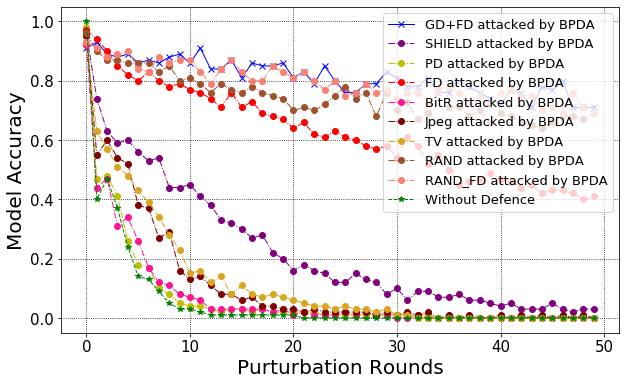

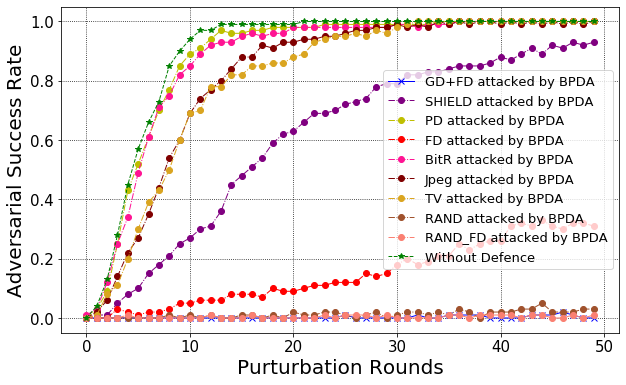

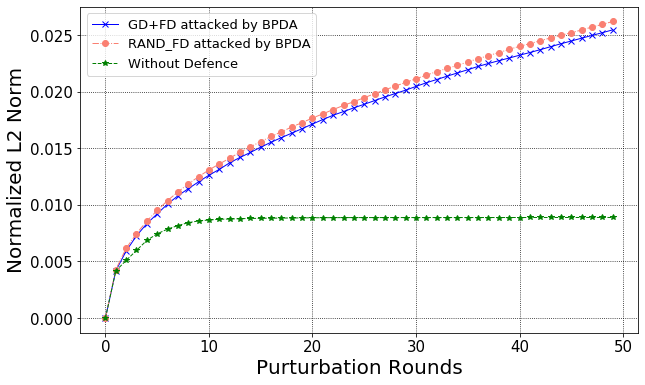

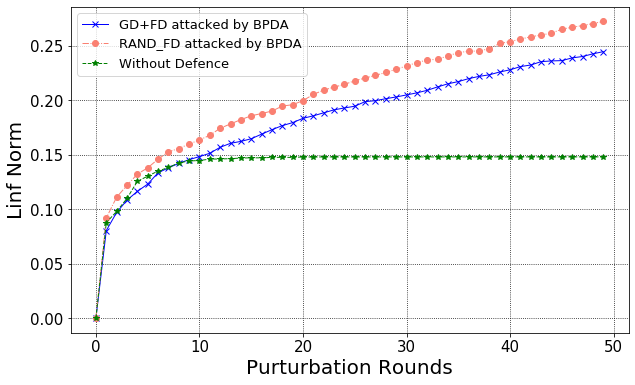

In [12]:
totalrounds = 50

plt.figure(figsize=(10,6))
plt.plot(np.arange(totalrounds),AccList_BPDA, color="b",label='GD+FD attacked by BPDA', linestyle="-", marker="x", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_SHIELD_BPDA, color="purple",label='SHIELD attacked by BPDA', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_PD_BPDA, color="y",label='PD attacked by BPDA', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_FD_BPDA, color="r",label='FD attacked by BPDA', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_BitR_BPDA, color="deeppink",label='BitR attacked by BPDA', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_Jpeg_BPDA, color="maroon",label='Jpeg attacked by BPDA', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_TV_BPDA, color="goldenrod",label='TV attacked by BPDA', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_RAND_BPDA, color="sienna",label='RAND attacked by BPDA', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_RAND_FD_BPDA, color="salmon",label='RAND_FD attacked by BPDA', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList, color="g", label='Without Defence',linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("Model Accuracy",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/BPDA_ModelAcc.png',bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
plt.plot(np.arange(totalrounds),SuccessList_BPDA, color="b", label='GD+FD attacked by BPDA',linestyle="-", marker="x", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_SHIELD_BPDA, color="purple", label='SHIELD attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_PD_BPDA, color="y", label='PD attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_FD_BPDA, color="r", label='FD attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_BitR_BPDA, color="deeppink", label='BitR attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_Jpeg_BPDA, color="maroon", label='Jpeg attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_TV_BPDA, color="goldenrod", label='TV attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_RAND_BPDA, color="sienna", label='RAND attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_RAND_FD_BPDA, color="salmon", label='RAND_FD attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList, color="g", label='Without Defence',linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("Adversarial Success Rate",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/BPDA_AtkSucc.png',bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,6))
plt.plot(np.arange(totalrounds),L2List_BPDA, color="b", label='GD+FD attacked by BPDA',linestyle="-", marker="x", linewidth=1.0)
plt.plot(np.arange(totalrounds),L2List_RAND_FD_BPDA, color="salmon", label='RAND_FD attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),L2List, color="g",  label='Without Defence',linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("Normalized L2 Norm",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/BPDA_AEL2.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.arange(totalrounds),LinfList_BPDA, color="b", label='GD+FD attacked by BPDA',linestyle="-", marker="x", linewidth=1.0)
plt.plot(np.arange(totalrounds),LinfList_RAND_FD_BPDA, color="salmon", label='RAND_FD attacked by BPDA',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),LinfList, color="g",  label='Without Defence',linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("Linf Norm",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/BPDA_AELinf.png',bbox_inches='tight')
plt.show()